**Read
- https://www.jittagornp.me/blog/what-is-firewall/

Columns Description
- Source Port, Client Source Port 
- Destination Port, Client Destination Port 
- NAT Source Port, Network Address Translation Source Port 
- NAT Destination Port, Network Address Translation Destination Port 
- Elapsed Time (sec), Elapsed Time for flow 
- Bytes, Total Bytes 
- Bytes Sent, Bytes Sent 
- Bytes Received, Bytes Received 
- Packets, Total Packets 
- pkts_sent, Packets Sent 
- pkts_received, Packets Received
- Action, Class (allow, deny, drop, reset-both)

- Allow, Allows the internet traffic. 
- Deny, Blocks traffic and enforces the default Deny Action defined for the application that is being denied. 
- Drop, Silently drops the traffic; for an application, it overrides the default deny action. A TCP reset is not sent to the host/application. 
- Reset-Both, Sends a TCP reset to both the client-side and server-side devices

NAT stands for network address translation. It’s a way to map multiple private addresses inside a local network to a public IP address before transferring the information onto the internet. Organizations that want multiple devices to employ a single IP address use NAT, as do most home routers

Idea
- คิดว่า feature packet ทั้งหมด drop ทิ้งได้ เพราะ  corr กับ bytes
- ทำรูป flow pipeline 

To do
- clean -> done
- EDA -> done
- encoding catagorical data -> done with pd getdummie
- dicision tree adjust branch
- random forest
- knn
- xgboost
- cart
- handle imbalance data -> done with smotenc
    - upsampling with smote make perf getting worse because smote is for datasets containing only numerical feature -> try smotenc that is for dataset containing numerical and categorical features -> done

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC

# plt.style.use('ggplot')

In [51]:
# Import data
df = pd.read_csv('Firewall_Log.csv')

In [52]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [54]:
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [55]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


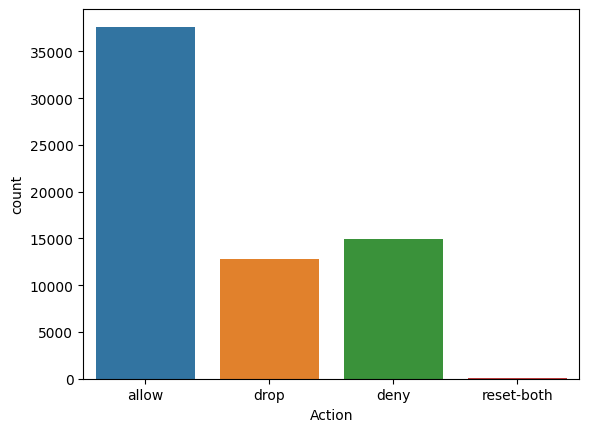

In [56]:
sns.countplot(data=df, x="Action")
plt.show()

In [57]:
count_action_allow = len(df[df["Action"]=="allow"])
count_action_drop = len(df[df["Action"]=="drop"])
count_action_deny = len(df[df["Action"]=="deny"])
count_action_reset = len(df[df["Action"]=="reset-both"])

count_action = count_action_allow + count_action_drop + count_action_deny + count_action_reset

percentage_of_action_allow = count_action_allow/count_action
percentage_of_action_drop = count_action_drop/count_action
percentage_of_action_deny = count_action_deny/count_action
percentage_of_action_reset = count_action_reset/count_action

print(f"percentage of allow action is {round(percentage_of_action_allow*100, 2)} %")
print(f"percentage of drop action is {round(percentage_of_action_drop*100, 2)} %")
print(f"percentage of deny action is {round(percentage_of_action_deny*100, 2)} %")
print(f"percentage of reset action is {round(percentage_of_action_reset*100, 2)} %")

percentage of allow action is 57.44 %
percentage of drop action is 19.61 %
percentage of deny action is 22.87 %
percentage of reset action is 0.08 %


In [58]:
# # count the occurrences of each unique value
# action_counts = df['Action'].value_counts()

# # plot the count of unique values
# ax = action_counts.plot(kind='bar')
# ax.set_title('Count of Action Values')

# for i in ax.patches:
#     ax.text(i.get_x()+0.1, i.get_height(), str(int(i.get_height())), fontsize=11, color='black')
# plt.show()

# # pie chart
# action_counts.plot.pie(autopct='%.2f')
# plt.show()

มี imbalance data ใน action == reset-both

In [59]:
# from sklearn.utils import resample


# allow = df[df.Action=='allow']
# deny = df[df.Action=='deny']
# drop = df[df.Action=='drop']
# reset_both = df[df.Action=='reset-both']

# # oversample the minority classes
# deny_oversampled = resample(deny, replace=True, n_samples=len(allow), random_state=42)
# drop_oversampled = resample(drop, replace=True, n_samples=len(allow), random_state=42)
# reset_both_oversampled = resample(reset_both, replace=True, n_samples=len(allow), random_state=42)

# # combine the resampled classes with the majority class
# oversampled_df = pd.concat([allow, deny_oversampled, drop_oversampled, reset_both_oversampled])

# # check the class distribution
# oversampled_df['Action'].value_counts()

In [60]:
# Convert port column to str type
col = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']
for i in col:
    df[i] = df[i].astype(str)

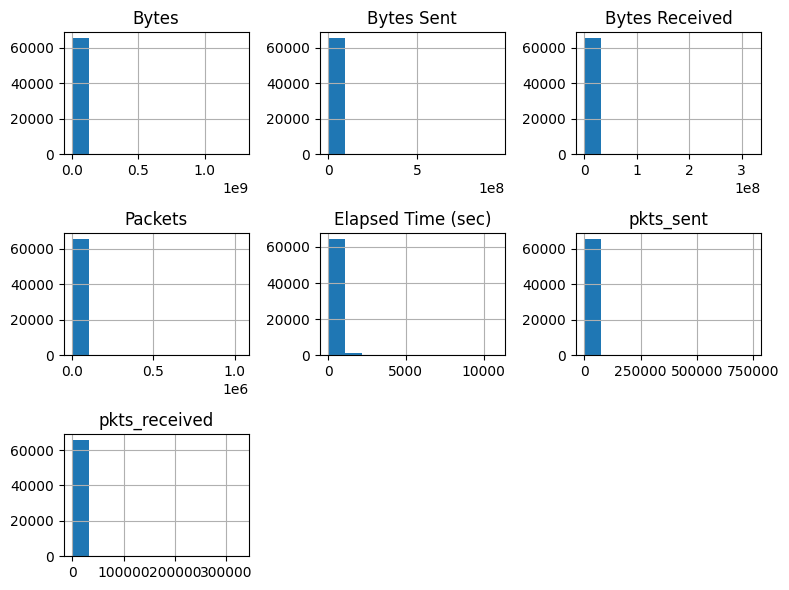

In [61]:
# create histogram of numerical feature
df.hist(figsize = (8, 6))
plt.tight_layout()
plt.show()

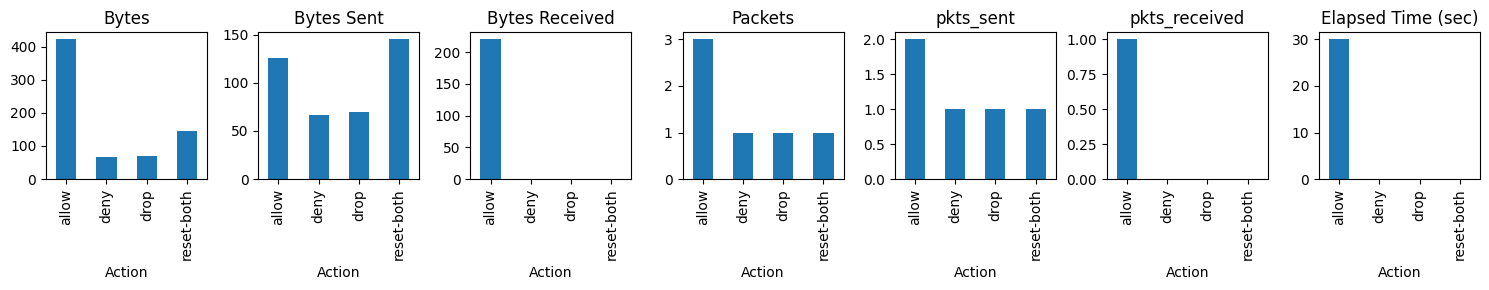

In [62]:
# ดูความต่างของ feature data แต่ละ action เห็นว่ามี pattern allow จะ byte, pkt, time เยอะกว่า action อื่น ส่วน action อื่นเท่ากันหมด
fig, axs = plt.subplots(ncols=7, figsize=(15, 3))

for i, col in enumerate(['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'pkts_sent', 'pkts_received', 'Elapsed Time (sec)']):
    action_median = df.groupby(['Action'])[col].median()
    action_median.plot(kind='bar', ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

In [63]:
# # create histogram
# columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 6))
# axs = axs.flatten()

# # Create a histogram for each selected column on a separate subplot
# for i, col in enumerate(columns):
#     axs[i].hist(df[col], bins=20)
#     axs[i].set_title(col)

# plt.tight_layout()
# plt.show()

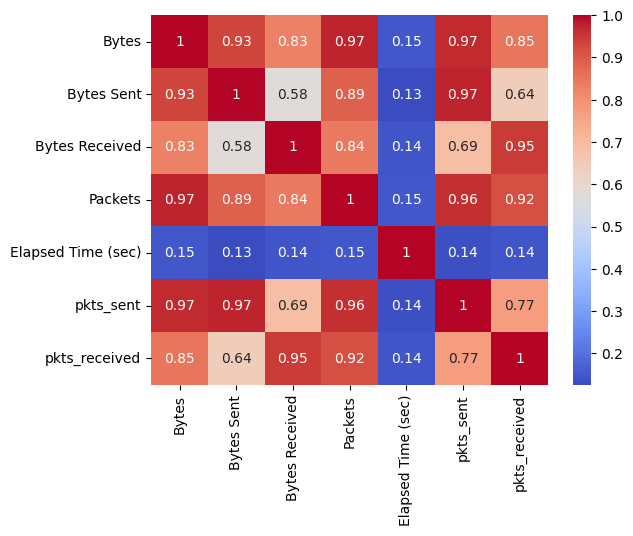

In [64]:
# Create a heatmap of the correlation coefficients
columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']
corr_matrix = df[columns].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# packets และ bytes corr=~1 ตัด pkt ทิ้งได้

In [65]:
# sns.pairplot(data=df, hue = "Action")
# plt.show()

In [66]:
# Since the data in columns is not form in normal distribution so we will apply Standardization
scaler = StandardScaler()
df[columns] = scaler.fit_transform(df[columns])

df.head(3)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,-0.012551,-0.027197
1,56258,3389,56258,3389,allow,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,-0.009755,-0.023598
2,6881,50321,43265,50321,allow,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,-0.012551,-0.027197


In [67]:
# onehot encoding
df = pd.get_dummies(df, columns=['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port'])

df.head(3)

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Port_0,Source Port_10000,...,NAT Destination Port_9587,NAT Destination Port_9595,NAT Destination Port_9600,NAT Destination Port_9703,NAT Destination Port_9869,NAT Destination Port_9912,NAT Destination Port_993,NAT Destination Port_995,NAT Destination Port_9992,NAT Destination Port_9999
0,allow,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,-0.012551,-0.027197,False,False,...,False,False,False,False,False,False,False,False,False,False
1,allow,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,-0.009755,-0.023598,False,False,...,False,False,False,False,False,False,False,False,False,False
2,allow,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,-0.012551,-0.027197,False,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
X = df.drop(['Action', 'Packets', 'pkts_sent', 'pkts_received'], axis=1)
y = df['Action']

In [69]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# label_encoded_df = X.copy()
# for col in label_encoded_df.select_dtypes(include='O').columns:
#     label_encoded_df[col]=le.fit_transform(label_encoded_df[col])

In [70]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# for col in X.select_dtypes(include='O').columns:
#     X[col]=le.fit_transform(df[col])

In [71]:
# X = df.drop(['Action', 'Bytes Sent', 'Bytes Received', 'pkts_sent', 'pkts_received'], axis=1)
# y = df['Action']

In [72]:
# X = df.drop(['Action', 'Elapsed Time (sec)'], axis=1)
# y = df['Action']

In [73]:
# from sklearn.preprocessing import OneHotEncoder

# # create a list of column names to encode
# cols_to_encode = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']

# # create a OneHotEncoder object
# ohe = OneHotEncoder(sparse_output=False)
# ohe.fit_transform(df[['Source Port']])

In [74]:
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=50)

# decision tree

In [75]:
treeclassifier = DecisionTreeClassifier()
treeclassifier.fit(X_train, y_train)
pred = treeclassifier.predict(X_test)

In [76]:
# # handle imbalance data with smotenc
# sm = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 3]) # define categorical features ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']
# X_sm, y_sm = sm.fit_resample(X_train, y_train)
# y_sm.value_counts()

In [77]:
# treeclassifier.fit(X_sm, y_sm)
# smpred = treeclassifier.predict(X_test)

In [78]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[7532    1    0    0]
 [   0 2938   13    0]
 [   0    3 2607    0]
 [   0    2    0   11]]
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7533
        deny       1.00      1.00      1.00      2951
        drop       1.00      1.00      1.00      2610
  reset-both       1.00      0.85      0.92        13

    accuracy                           1.00     13107
   macro avg       1.00      0.96      0.98     13107
weighted avg       1.00      1.00      1.00     13107



In [ ]:
# from sklearn.metrics import confusion_matrix,classification_report
# print(confusion_matrix(y_test,smpred))
# print(classification_report(y_test,smpred))

# KNN

https://www.kaggle.com/code/shrutimechlearn/step-by-step-diabetes-classification-knn-detailed

In [ ]:
import math
max_k = round(math.sqrt(len(X_train)))
print(f"maximun k = {max_k}")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


test_scores = []
train_scores = []

for i in range(1, 5):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [ ]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

In [ ]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

In [ ]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')

# xgboost

https://www.kaggle.com/code/lucidlenn/data-analysis-and-classification-using-xgboost

In [79]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['allow' 'deny' 'drop' 'reset-both']

In [ ]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

In [ ]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

In [ ]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))